In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from Causal_inference import granger_causality,add_causality_dataset, generate_synthetic
from time import time
import pmdarima as pm
from tqdm import tqdm
from statsmodels.tsa.arima_model import ARMA
from TimeSeries import TimeSeries
from copy import deepcopy

In [2]:
import os
cwd = os.getcwd()
print(cwd)

def plot(x):
    l = np.arange(x.shape[0])
    plt.plot(l, x, c='blue')
    plt.show()

/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine


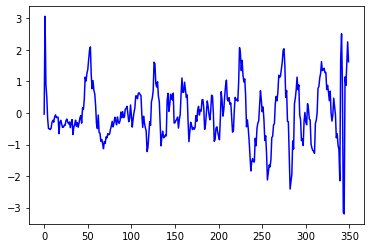

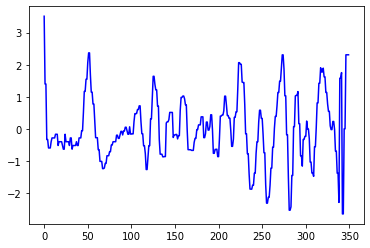

In [3]:
effect_name = "FaceFour_mixsd0.1_0.1_causaldb"
causal_name = 'FaceFour_causaldb'

effect = np.load(cwd+"/test_files/"+'FaceFour_randomsd0.1_effectdb.npy')
plot(effect[0])

causal = np.load(cwd+"/test_files/"+'FaceFour_causaldb.npy')
plot(causal[0])

true_mat = np.load(cwd+"/test_files/"+'FaceFour_split_truemat.npy')
# for i in range(1,200, 2):
#     noisydata[i] += random_walk(m = 96, sd= 0.1)


# dataframe = pp.DataFrame(effect, 
#                          datatime = np.arange(len(effect)), 
#                          var_names=np.arange(len(effect)))
# plt.show()

In [4]:
from kNN import kNN, kNN_with_pq_NCC, kNN_with_pq_SINK, MAP, avg_recall_measure
from time import time
from Causal_inference import check_with_original
import Representation

In [5]:
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/independence_tests/cmiknn.py:15: UserWarning: cannot import name 'tigramite_cython_code' from 'tigramite' (/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/__init__.py)
  warnings.warn(str(e))


In [6]:
neighbor_param =[2, 5, 10, 100]

In [7]:
n1 = causal.shape[0]
n2 = effect.shape[0]

In [8]:
import importlib
importlib.reload(tigramite)
import json

best_gamma = 5
alpha_level = 0.01

#try different p-values, different alpha levels

var_names = np.arange(len(effect))

df = pp.DataFrame(effect.transpose(), datatime = np.arange(len(effect[0])),var_names=var_names)
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=0)
pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)
 
            
dict_results={}
dict_results["p-values"] = results['p_matrix'].round(3)
dict_results["MCI partial correlations"] = results['val_matrix'].round(3)
#plotting
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
dict_results["q_matrix"] = q_matrix.round(3)
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = alpha_level)
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
            val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
dict_results["link_matrix"] = link_matrix

compare_matrix = np.empty(shape=[0, 1])
for each in link_matrix:
    compare_matrix = np.append(compare_matrix, each[2])


check_results = check_with_original(true_mat, link_matrix) #[prec, rec, F1]
dict_results["precision"] = check_results[0]
dict_results["recall"] = check_results[1]
dict_results["f-score"] = check_results[2]

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    )
plt.savefig(f"{effect_name}_process_graph.png")
plt.clf()
plt.close()
tp.plot_time_series_graph(
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    )
plt.savefig(f"{effect_name}_time_series_graph.png")
plt.clf()
plt.close()


with open('data.json', 'w') as f:
    json.dump(dict_results, f)


## Significant links at alpha = 0.01:

    Variable 0 has 7 link(s):
        (60 -2): pval = 0.00000 | qval = 0.00000 | val =  0.377
        (0 -8): pval = 0.00000 | qval = 0.00001 | val = -0.331
        (0 -1): pval = 0.00000 | qval = 0.00002 | val =  0.320
        (68  0): pval = 0.00036 | qval = 0.00036 | val =  0.210
        (57  0): pval = 0.00052 | qval = 0.00052 | val =  0.204
        (95  0): pval = 0.00064 | qval = 0.00064 | val =  0.199
        (26  0): pval = 0.00985 | qval = 0.00985 | val =  0.151

    Variable 1 has 5 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val =  0.355
        (83  0): pval = 0.00000 | qval = 0.00000 | val =  0.340
        (38 -6): pval = 0.00000 | qval = 0.00005 | val =  0.308
        (26  0): pval = 0.00028 | qval = 0.00028 | val = -0.213
        (43  0): pval = 0.00233 | qval = 0.00233 | val =  0.178

    Variable 2 has 7 link(s):
        (2 -1): pval = 0.00000 | qval = 0.00000 | val =  0.454
        (2 -3): pval = 0.00000 | qval = 

NameError: name 'compare_matrix' is not defined

In [47]:
import importlib
importlib.reload(tigramite)

#run pcmci without knn
#show GRAIL with kNN is faster
#link matrix

#store results in dict, then dump as json
#do for GRAIL representation
#representation = Representation.GRAIL(kernel="SINK", d = 100, gamma = best_gamma)
#TRAIN_TS, TEST_TS = representation.get_rep_train_test(effect, causal)
counter = 0
best_gamma = 5
alpha_level = 0.01
for neighbor_num in neighbor_param:
    if neighbor_num >= n2:
        continue
    # neighbors, _, _ = kNN(TRAIN_TS, TEST_TS, method="ED", k=neighbor_num, representation=None, use_exact_rep=True,
    #                         pq_method=None) #changed pq
    exact_neighbors, _, _ = kNN(effect, causal, method="SINK", k=neighbor_num, representation=None, gamma_val=best_gamma)
    #returns list, exact_neighbors[i], k-nearest neighbors of i, if k=5, k nearest neighbors, 
    # could be time series 6, 8, 10, indices of th enearest time series
    #k is selected from neighbors params

    # knn_map_accuracy = MAP(exact_neighbors, neighbors)
    # knn_recall_accuracy = avg_recall_measure(exact_neighbors, neighbors)
    dict_results = {}

    #for each time series
    for i in range(n1):
        #for each k nearest neighbor
        for j in exact_neighbors[i]:
            f = np.vstack((effect[j], causal[i]))
            f = f.transpose()
            # print(f.shape)
            var_names = np.arange(len(effect[j]))
            # print(len(effect[j]))
            df = pp.DataFrame(f, datatime = np.arange(len(effect[0])),var_names=var_names)
            parcorr = ParCorr(significance='analytic')
            pcmci = PCMCI(
                dataframe=df, 
                cond_ind_test=parcorr,
                verbosity=0)
            pcmci.verbosity = 0
            results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)
            if counter == 0:
                print(results)
                counter +=1 
            
            dict_results[(i, j)]={}
            dict_results[(i, j)]["p-values"] = results['p_matrix'].round(3)
            dict_results[(i, j)]["MCI partial correlations"] = results['val_matrix'].round(3)
            #plotting
            q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
            dict_results[(i, j)]["q_matrix"] = q_matrix.round(3)
            pcmci.print_significant_links(
                    p_matrix = results['p_matrix'], 
                    q_matrix = q_matrix,
                    val_matrix = results['val_matrix'],
                    alpha_level = alpha_level)
            link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
            dict_results[(i, j)]["link_matrix"] = link_matrix
            check_results = check_with_original(true_mat, link_matrix) #[prec, rec, F1]
            dict_results[(i, j)]["precision"] = check_results[0]
            dict_results[(i, j)]["recall"] = check_results[1]
            dict_results[(i, j)]["f-score"] = check_results[2]
            tp.plot_graph(
                val_matrix=results['val_matrix'],
                link_matrix=link_matrix,
                var_names=var_names,
                link_colorbar_label='cross-MCI (edges)',
                node_colorbar_label='auto-MCI (nodes)',
                )
            plt.savefig(f"{i}-{j}_process_graph.png")
            plt.clf()
            plt.close()
            tp.plot_time_series_graph(
                figsize=(8, 8),
                node_size=0.05,
                val_matrix=results['val_matrix'],
                link_matrix=link_matrix,
                var_names=var_names,
                link_colorbar_label='MCI',
                )
            plt.savefig(f"{i}-{j}_time_series_graph.png")
            plt.clf()
            plt.close()
            
            
            with open('data.json', 'w') as f:
                json.dump(res_dict, f)



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 4 link(s):
    [pc_alpha = 0.05]
        (0 -4): max_pval = 0.00311, min_val = -0.162
        (1 -4): max_pval = 0.00311, min_val = -0.162
        (0 -2): max_pval = 0.00810, min_val = -0.145
        (1 -2): max_pval = 0.00810, min_val = -0.145

    Variable 1 has 4 link(s):
    [pc_alpha = 0.05]
        (0 -4): max_pval = 0.00311, min_val = -0.162
        (1 -4): max_pval = 0.00311, min_val = -0.162
        (0 -2): max_pval = 0.00810, min_val = -0.145
        (1 -2): max_pval = 0.00810, min_val = -0.145

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 8
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable 0 has 11 link(s):
        (1 

/Users/ianyuen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())



## Resulting lagged parent (super)sets:

    Variable 0 has 4 link(s):
    [pc_alpha = 0.2]
        (0 -1): max_pval = 0.00000, min_val =  0.617
        (1 -1): max_pval = 0.00000, min_val =  0.413
        (0 -8): max_pval = 0.00559, min_val = -0.152
        (0 -5): max_pval = 0.14947, min_val =  0.079

    Variable 1 has 7 link(s):
    [pc_alpha = 0.5]
        (1 -1): max_pval = 0.00000, min_val =  0.703
        (1 -8): max_pval = 0.00926, min_val = -0.143
        (0 -6): max_pval = 0.02320, min_val = -0.125
        (1 -6): max_pval = 0.19888, min_val =  0.071
        (0 -2): max_pval = 0.41039, min_val = -0.045
        (1 -4): max_pval = 0.43864, min_val =  0.043
        (0 -3): max_pval = 0.45671, min_val = -0.041

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 8
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable 0 has 4 link(s):
        (0 -1): pval = 0.00000 | val =  0.554
        (1 -1): p

In [28]:
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

In [42]:
f = np.array([1,2,3])
g = np.array([4,5,6])

f = np.vstack((f, g))
print(f)

[[1 2 3]
 [4 5 6]]


/Users/ianyuen/Documents/GitHub/RA_time_series/time_series_ra/RepLearningEngine/tigramite/data_processing.py:66: UserWarning: data.shape = (112, 350), is it of shape (observations, variables) ?
  warnings.warn("data.shape = %s," % str(self.values.shape) +


ValueError: x and y must have same first dimension, but have shapes (350,) and (112,)

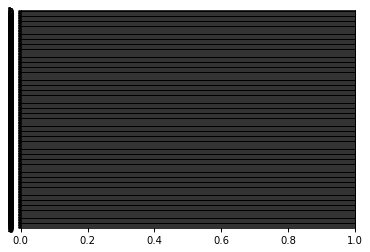

In [17]:
# sample_set_data = np.empty(shape=[96, 1])
# var_names = []
# for i in range(5):
#     n = noisydata[i].reshape(len(noisydata[i]), 1)
#     name = f"noisydata{i}"
#     var_names.append(name)
#     if i ==1:
#         sample_set_data = n
#     else:
#         sample_set_data = np.hstack((sample_set_data, n))

# T = len(noisydata[3])
# data, true_parents_neighbors = pp.var_process(sample_set_data, T=T)

# n = noisydata[3].reshape(len(noisydata[3]), 1)
var_names = np.arange(len(effect[0]))
df = pp.DataFrame(effect, datatime = np.arange(len(effect[0])),var_names=var_names)
tp.plot_timeseries(df)


1: PCMCI

initialize pcmi object

In [44]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=1)

Unconditional Dependencies, Lagged Correlations

Choosing the tau_max


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


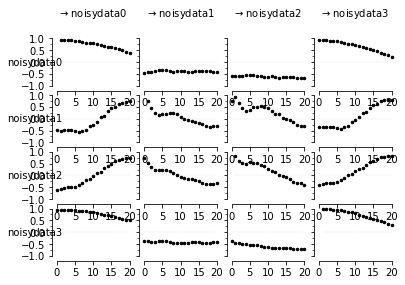

In [45]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [46]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable noisydata0 has 7 link(s):
    [pc_alpha = 0.4]
        (noisydata0 -3): max_pval = 0.00008, min_val =  0.438
        (noisydata0 -1): max_pval = 0.00011, min_val =  0.429
        (noisydata0 -4): max_pval = 0.00957, min_val = -0.297
        (noisydata3 -1): max_pval = 0.01529, min_val =  0.272
        (noisydata3 -2): max_pval = 0.18144, min_val =  0.152
        (noisydata0 -2): max_pval = 0.20983, min_val = -0.144
        (noisydata2 -4): max_pval = 0.31409, min_val = -0.118

    Variable noisydata1 has 2 link(s):
    [pc_alpha = 0.4]
        (noisydata1 -1): max_pval = 0.00000, min_val =  0.593
        (noisydata0 -8): max_pval = 0.34804, min_val = -0.108

    Variable noisydata2 has 7 link(s):
    [pc_alpha = 0.5]
        (n

In [1]:
print(results)

NameError: name 'results' is not defined

p-values

correlations

In [47]:

print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.012 0.001 0.077 0.945 0.4   0.921 0.215]
  [0.265 0.373 0.774 0.766 0.833 0.333 0.691 0.63  0.231]
  [0.74  0.195 0.882 0.547 0.936 0.899 0.765 0.813 0.717]
  [0.098 0.918 0.341 0.088 0.563 0.255 0.374 0.824 0.078]]

 [[0.265 0.369 0.261 0.253 0.327 0.12  0.272 0.54  0.33 ]
  [1.    0.    0.845 0.115 0.025 0.048 0.435 0.981 0.261]
  [0.562 0.    0.05  0.036 0.001 0.92  0.324 0.    0.933]
  [0.729 0.108 0.245 0.533 0.143 0.475 0.228 0.306 0.128]]

 [[0.74  0.453 0.003 0.045 0.011 0.196 0.106 0.15  0.208]
  [0.562 0.161 0.641 0.854 0.329 0.826 0.945 0.313 0.031]
  [1.    0.    0.    0.001 0.083 0.811 0.004 0.852 0.771]
  [0.02  0.221 0.44  0.208 0.149 0.04  0.16  0.027 0.077]]

 [[0.098 0.005 0.111 0.464 0.304 0.354 0.882 0.618 0.791]
  [0.729 0.658 0.099 0.729 0.757 0.878 0.005 0.472 0.451]
  [0.02  0.078 0.189 0.493 0.981 0.42  0.579 0.257 0.561]
  [1.    0.    0.    0.    0.    0.    0.003 0.087 0.524]]]
MCI partial correlations
[[[ 0.    0.51 -0.3   0.4  -0.

In [48]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

print(results['val_matrix'])


## Significant links at alpha = 0.01:

    Variable noisydata0 has 2 link(s):
        (noisydata0 -1): pval = 0.00000 | qval = 0.00006 | val =  0.512
        (noisydata0 -3): pval = 0.00063 | qval = 0.00625 | val =  0.404

    Variable noisydata1 has 1 link(s):
        (noisydata1 -1): pval = 0.00000 | qval = 0.00000 | val =  0.589

    Variable noisydata2 has 6 link(s):
        (noisydata1 -1): pval = 0.00000 | qval = 0.00000 | val =  0.953
        (noisydata2 -1): pval = 0.00000 | qval = 0.00000 | val =  0.832
        (noisydata2 -2): pval = 0.00000 | qval = 0.00000 | val =  0.618
        (noisydata1 -7): pval = 0.00005 | qval = 0.00055 | val = -0.460
        (noisydata2 -3): pval = 0.00062 | qval = 0.00625 | val =  0.405
        (noisydata1 -4): pval = 0.00077 | qval = 0.00708 | val = -0.385

    Variable noisydata3 has 5 link(s):
        (noisydata3 -1): pval = 0.00000 | qval = 0.00000 | val =  0.844
        (noisydata3 -5): pval = 0.00000 | qval = 0.00000 | val =  0.714
        (

links occuring at multiple lags between two variables?

In [49]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

AttributeError: 'Polygon' object has no attribute 'clear'

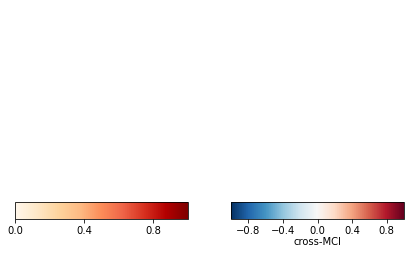

In [50]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

2: PCMCI-plus

In [ ]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Running Tigramite BivCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10


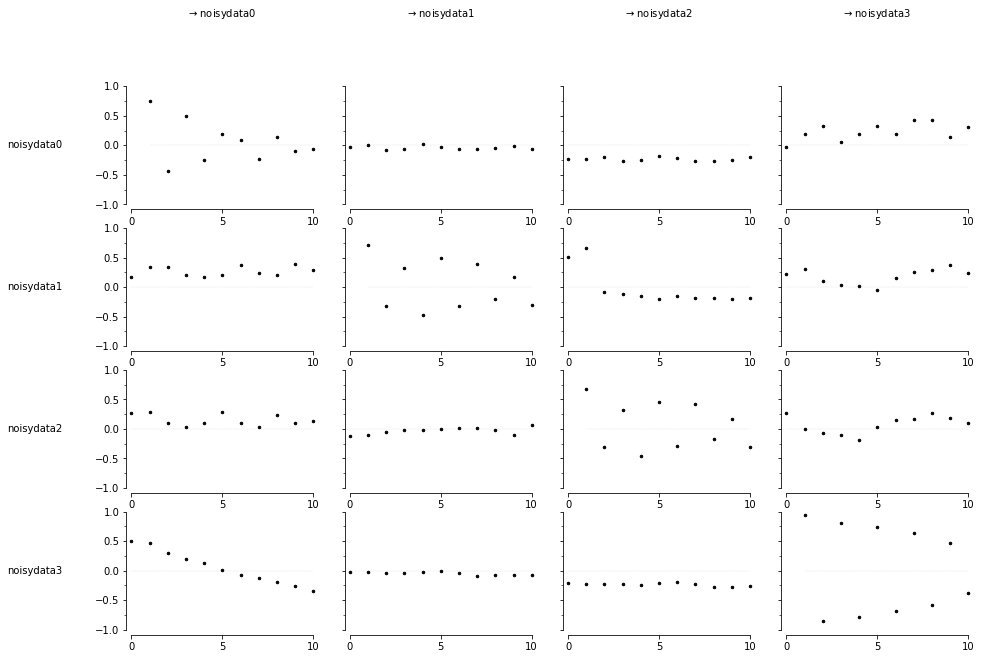

In [ ]:
correlations = pcmci.run_bivci(tau_max=10, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                   setup_args={'var_names':var_names, 'figsize':(15, 10),
                                    'x_base':5, 'y_base':.5})

In [ ]:
tau_max = 3
pc_alpha = 0.01
pcmci.verbosity = 2

results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable noisydata0

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (noisydata0 -1) --> noisydata0 (1/12):
    Subset 0: () gives pval = 0.00000 / val =  0.956
    No conditions of dimension 0 left.

    Link (noisydata0 -2) --> noisydata0 (2/12):
    Subset 0: () gives pval = 0.00000 / val =  0.904
    No conditions of dimension 0 left.

    Link (noisydata0 -3) --> noisydata0 (3/12):
    Subset 0: () gives pval = 0.00000 / val =  0.860
    No conditions of dimension 0 left.

    Link (noisydata1 -1) --> noisydata0 (4/12):
    Subset 0: () gives pval = 0.37007 / val =  0.096
    Non-significance detected.

    Link (noisydata1 -2) --> noisydata0 (5/12):
    Subset 0: () gives pval = 0.07481 / val =  0.189
    Non-significance detected.


In [ ]:
print("Graph")
print (results['graph'])
print("Adjacency MCI partial correlations")
print (results['val_matrix'].round(2))
print("Adjacency p-values")
print (results['p_matrix'].round(3))

Graph
[[['' '-->' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '-->' '' '']
  ['' '-->' '-->' '']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '' '' '']
  ['' '-->' '' '']
  ['' '' '' '']]

 [['' '-->' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '-->' '-->' '-->']]]
Adjacency MCI partial correlations
[[[ 0.    0.51 -0.06 -0.15]
  [ 0.05 -0.05 -0.13 -0.18]
  [-0.03 -0.18 -0.23 -0.03]
  [ 0.19 -0.17  0.11  0.03]]

 [[ 0.05  0.1   0.19  0.23]
  [ 0.    0.61  0.05  0.14]
  [-0.15  0.98 -0.95 -0.09]
  [ 0.13  0.09  0.17  0.23]]

 [[-0.03 -0.03  0.03  0.06]
  [-0.15 -0.04  0.06 -0.07]
  [ 0.    0.7   0.01  0.14]
  [-0.06 -0.08 -0.01  0.04]]

 [[ 0.19  0.54 -0.24 -0.  ]
  [ 0.13 -0.07 -0.13 -0.19]
  [-0.06 -0.22 -0.27 -0.23]
  [ 0.    0.9  -0.72  0.6 ]]]
Adjacency p-values
[[[1.    0.    0.595 0.166]
  [0.648 0.64  0.219 0.084]
  [0.81  0.084 0.031 0.795]
  [0.076 0.111 0.319 0.747]]

 [[0.648 0.37  0.075 0.029]
  [1.    0.    0.633 0.195]
  [0.174 0.    0.    0.

In [ ]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh',
                                                  exclude_contemporaneous=False)

In [ ]:
link_matrix = results['graph']

In [53]:
import importlib
importlib.reload(tp)

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    ); plt.show()

AttributeError: module 'tigramite.plotting' has no attribute 'reload'

AttributeError: 'Polygon' object has no attribute 'clear'

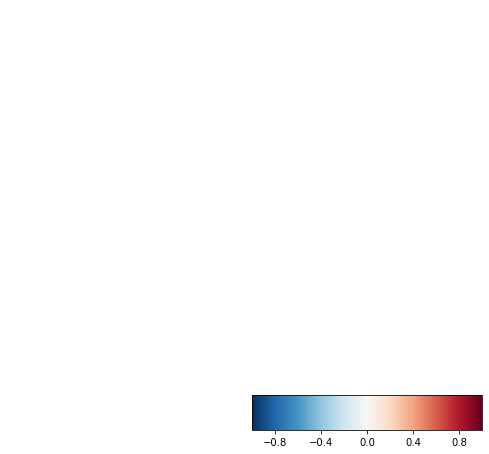

In [ ]:
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()